## Introduction
In this notebook, we will explore the [Corporación Favorita Grocery Sales Forecasting](https://www.kaggle.com/c/favorita-grocery-sales-forecasting) competition on Kaggle.
The goal of this competition is to predict the unit sales for thousands of items sold at different Favorita stores located in Ecuador.
We will use the data provided to train a model that can accurately forecast the sales for each item in each store.

To achieve our goals, we use trend features, moving averages, and SARIMAX to impute missing data.
For the actual model training, we use the combination of LightGBM, and CatBoost to predict the sales.
We also optimized our model using Optuna to find the best hyperparameters for both LightGBM and CatBoost.

---

## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

import lightgbm as lgb
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor

import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

In [2]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Function to Downcast Data Types
The function `downcast_df` is used to reduce the memory usage of the dataset by downcasting the data types of the columns.


In [3]:
# downcast data types
def downcast_df(df):
    # Downcast floating point columns to reduce size
    float_cols = df.select_dtypes(include=['float'])
    for col in float_cols.columns:
        df[col] = pd.to_numeric(df[col], downcast='float').astype('float32')

    # Downcast integer columns to reduce size
    int_cols = df.select_dtypes(include=['int'])
    for col in int_cols.columns:
        df[col] = pd.to_numeric(df[col], downcast='integer').astype('int32')

    # # Optional: Convert objects to category if the number of unique items is less than 50% of total non-null items
    # object_cols = df.select_dtypes(include=['object'])
    # for col in object_cols.columns:
    #     num_unique_values = len(df[col].unique())
    #     num_total_values = len(df[col])
    #     if num_unique_values / num_total_values < 0.5:
    #         df[col] = df[col].astype('category')

    return df

## Functions to Generate Trend Features
The following functions are used to generate trend features for the sales and transaction data.
We have a choice of moving average types to use, such as Simple Moving Average (SMA), Exponential Moving Average (EMA), Double Exponential Moving Average (DEMA), Weighted Moving Average (WMA), Relative Moving Average (RMA), and Hull Moving Average (HMA).

In [4]:
# Function to generate trend features
def sma(source, length):
    return source.rolling(window=length, min_periods=1).mean().astype('float32')

def ema(source, length):
    return source.ewm(span=length, adjust=False).mean().astype('float32')

def dema(source, length):
    return 2 * ema(source, length) - ema(ema(source, length), length).astype('float32')

def wma(source, length):
    weights = np.arange(1, length + 1)
    return source.rolling(window=length, min_periods=1).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True).astype('float32')

def rma(source, length):
    return source.ewm(alpha=1/length, adjust=False).mean().astype('float32')

def hma(source, length):
    half_length = length // 2
    sqrt_length = int(np.sqrt(length))
    wmaf = 2 * wma(source, half_length) - wma(source, length)
    return wma(wmaf, sqrt_length).astype('float32')

def selector(source, length, ma_type):
    if ma_type == 'sma':
        return sma(source, length)
    elif ma_type == 'ema':
        return ema(source, length)
    elif ma_type == 'dema':
        return dema(source, length)
    elif ma_type == 'wma':
        return wma(source, length)
    elif ma_type == 'rma':
        return rma(source, length)
    elif ma_type == 'hma':
        return hma(source, length)
    else:
        raise ValueError('Invalid moving average type')

def trend_features(dataframe, column, ma_types, lengths, lags):
    features = {}
    for average_type in ma_types:
        for length in lengths:
            ma_column = f'{column}_{average_type}_{length}'
            features[ma_column] = selector(dataframe[column], length, average_type)

            # Compute detrended data from the moving average
            features[f'{ma_column}_detrended'] = dataframe[column] - features[ma_column]

            # Compute differential of the moving average
            features[f'{ma_column}_diff'] = features[ma_column].diff().fillna(0)

            for lag in lags:
                # Apply lags to moving average
                lag_col_name = f'{ma_column}_lag_{lag}'
                features[lag_col_name] = features[ma_column].shift(lag)

                # Detrended data for lagged values
                features[f'{lag_col_name}_detrended'] = features[lag_col_name] - features[ma_column]

                # Differential for lagged values
                features[f'{lag_col_name}_diff'] = features[lag_col_name].diff().fillna(0)

    # Concatenate all new features to the original dataframe to prevent fragmentation
    dataframe = pd.concat([dataframe, pd.DataFrame(features, index=dataframe.index)], axis=1)

    # Fill any NaN values that might have been generated, we use the previous value to fill these
    # If there is none available, we use the next value
    # Use linear interpolation to fill missing values
    # dataframe.interpolate(method='linear', inplace=True)
    dataframe.fillna(method='ffill', inplace=True)
    dataframe.fillna(method='bfill', inplace=True)

    return dataframe

# Define a function to apply trend features to each group
def apply_trend_features(group, column):
    # Your existing function here, adjusted if necessary
    return trend_features(group, column, ma_type, ma_length, lags)

def impute_transactions(transactions, full_transactions, plot_store=None):
    # Convert date to datetime if not already
    transactions['date'] = pd.to_datetime(transactions['date'])
    full_transactions['date'] = pd.to_datetime(full_transactions['date'])

    # Sort the dataframes by date and store_nbr
    transactions = transactions.sort_values(['store_nbr', 'date'])
    full_transactions = full_transactions.sort_values(['store_nbr', 'date'])

    # Fill Christmas days with 0
    christmas_mask = (full_transactions['date'].dt.month == 12) & (full_transactions['date'].dt.day == 25)
    full_transactions.loc[christmas_mask, 'transactions'] = 0

    imputation_log = {}

    # Impute missing values for each store
    for store in tqdm(full_transactions['store_nbr'].unique()):
        store_data = full_transactions[full_transactions['store_nbr'] == store].copy()

        # Skip if no missing data for this store
        if not store_data['transactions'].isna().any():
            continue

        # Find the first non-NaN value
        first_valid_index = store_data['transactions'].first_valid_index()
        if first_valid_index is None:
            print(f"Warning: Store {store} has no valid data. Skipping.")
            continue

        first_valid_date = store_data.loc[first_valid_index, 'date']

        # Handle the period before the first valid data
        early_missing_mask = (store_data['date'] < first_valid_date) & store_data['transactions'].isna()
        if early_missing_mask.any():
            # If the missing period is short (less than a month), use forward fill
            if (first_valid_date - store_data['date'].min()).days < 30:
                store_data.loc[early_missing_mask, 'transactions'] = store_data.loc[first_valid_index, 'transactions']
            else:
                # For longer periods, use a combination of seasonal patterns and initial performance
                initial_month_data = store_data.loc[store_data['date'] < first_valid_date + pd.Timedelta(days=30), 'transactions']
                initial_month_data = initial_month_data.dropna()

                if len(initial_month_data) > 0:
                    avg_initial_performance = initial_month_data.mean()
                    day_of_week_factor = store_data.loc[early_missing_mask, 'date'].dt.dayofweek.map(
                        lambda x: 1 + 0.1 * (3 - abs(3 - x))  # Assuming weekends (5,6) have higher sales
                    )
                    store_data.loc[early_missing_mask, 'transactions'] = avg_initial_performance * day_of_week_factor
                else:
                    print(f"Warning: Not enough initial data for store {store}. Using forward fill.")
                    store_data.loc[early_missing_mask, 'transactions'] = store_data.loc[first_valid_index, 'transactions']

        # Prepare data for SARIMAX
        y = store_data['transactions']

        # Perform seasonal decomposition
        y_filled = y.fillna(method='ffill').fillna(method='bfill')
        decomposition = seasonal_decompose(y_filled, model='additive', period=7)

        # Fit SARIMAX model
        model = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
        results = model.fit(disp=False)

        # Generate predictions for all values
        predicted = results.predict()

        # Fill remaining missing values with predictions
        missing_mask = store_data['transactions'].isna()
        store_data.loc[missing_mask, 'transactions'] = predicted[missing_mask]

        # Update full_transactions with imputed values
        full_transactions.loc[store_data.index, 'transactions'] = store_data['transactions']

        # Log imputation details
        imputed_dates = store_data.loc[missing_mask, 'date']
        imputed_values = store_data.loc[missing_mask, 'transactions']
        imputation_log[store] = pd.DataFrame({'date': imputed_dates, 'imputed_value': imputed_values})

        # Plot for specified store
        if store == plot_store:
            plt.figure(figsize=(20, 15))
            plt.subplot(411)
            plt.plot(store_data['date'], y, label='Original')
            plt.plot(store_data.loc[missing_mask, 'date'], store_data.loc[missing_mask, 'transactions'], 'ro', label='Imputed', alpha=0.7)
            plt.title(f'Store {store} - Original and Imputed')
            plt.legend()

            plt.subplot(412)
            plt.plot(decomposition.trend)
            plt.title('Trend')

            plt.subplot(413)
            plt.plot(decomposition.seasonal)
            plt.title('Seasonal')

            plt.subplot(414)
            plt.plot(decomposition.resid)
            plt.title('Residual')

            plt.tight_layout()
            plt.show()

    return full_transactions, imputation_log

## Load Data
We will load the train, test, oil, holidays, stores, transactions, and sample_submission datasets.
Then, we will downcast the data types to save memory.


In [5]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')
stores = pd.read_csv('stores.csv')
transactions = pd.read_csv('transactions.csv')

# Downcast data types
train = downcast_df(train)
test = downcast_df(test)
oil = downcast_df(oil)
holidays = downcast_df(holidays)
stores = downcast_df(stores)
transactions = downcast_df(transactions)

# Save original ID column for later use
train['original_id'] = train['id']
test['original_id'] = test['id']

# Convert date columns to datetime
for df in [train, test, oil, holidays, transactions]:
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

# Sort dataframes
train = train.sort_values(by=['date', 'store_nbr', 'family'])
test = test.sort_values(by=['date', 'store_nbr', 'family'])
oil = oil.sort_values('date')
holidays = holidays.sort_values('date')
stores = stores.sort_values('store_nbr')
transactions = transactions.sort_values(['date', 'store_nbr'])

## Feature Hyperparameters
The following hyperparameters are used for generating trend features for the sales and transaction data.

In [6]:
# Hyperparameters
ma_length = [3, 7, 28, 91]
ma_type = ['ema']
lags = [1, 7, 28]

## Store Data Feature Engineering
This section focuses on analyzing the store data.
To extract useful information from the store data, we will perform the following steps:
1. Clean and standardize the cluster values.
2. Create and encode a state-city pair.
3. Convert the state-city pair to binary.
4. Split the binary string into separate columns.
5. Drop unnecessary columns.
6. Downcast the data types to save memory.

In [7]:
def process_stores(stores):
    # Clean and standardize cluster values
    stores['cluster'] = stores['cluster'].astype(str).str.strip()
    stores['cluster'] = stores['cluster'].replace({'Cluster 1': '1'})
    known_clusters = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
    stores['cluster'] = pd.Categorical(stores['cluster'], categories=known_clusters)
    stores = pd.get_dummies(stores, columns=['cluster', 'type'])

    # Create and encode a state-city pair
    stores['state_city'] = stores['state'] + '_' + stores['city']
    stores['state_city'] = pd.Categorical(stores['state_city']).codes

    max_bits = len(bin(max(stores['state_city']))[2:])  # Maximum number of bits required

    # Function to convert integer to padded binary string
    def int_to_binary(x):
        return format(x, f'0{max_bits}b')

    # Apply the function to convert each unique code to binary
    stores['binary_code'] = stores['state_city'].apply(int_to_binary)

    # Split the binary string into separate columns
    for i in range(max_bits):
        stores[f'bit_{i}'] = stores['binary_code'].apply(lambda x: int(x[i]))

    binary_columns = [f'bit_{i}' for i in range(max_bits)]
    stores = pd.get_dummies(stores, columns=binary_columns, drop_first=True)

    # Drop unnecessary columns
    columns_to_drop = ['binary_code']
    stores = stores.drop(columns_to_drop, axis=1)

    return stores

stores = process_stores(stores)
stores = downcast_df(stores)
stores

,store_nbr,city,state,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,...,type_B,type_C,type_D,type_E,state_city,bit_0_1,bit_1_1,bit_2_1,bit_3_1,bit_4_1
0,1,Quito,Pichincha,False,False,False,False,False,False,False,...,False,False,True,False,18,True,False,False,True,False
1,2,Quito,Pichincha,False,False,False,False,False,False,False,...,False,False,True,False,18,True,False,False,True,False
2,3,Quito,Pichincha,False,False,False,False,False,False,False,...,False,False,True,False,18,True,False,False,True,False
3,4,Quito,Pichincha,False,False,False,False,False,False,False,...,False,False,True,False,18,True,False,False,True,False
4,5,Santo Domingo,Santo Domingo de los Tsachilas,False,False,False,True,False,False,False,...,False,False,True,False,20,True,False,True,False,False
5,6,Quito,Pichincha,False,False,False,False,False,False,False,...,False,False,True,False,18,True,False,False,True,False
6,7,Quito,Pichincha,False,False,False,False,False,False,False,...,False,False,True,False,18,True,False,False,True,False
7,8,Quito,Pichincha,False,False,False,False,False,False,False,...,False,False,True,False,18,True,False,False,True,False
8,9,Quito,Pichincha,False,False,False,False,False,True,False,...,True,False,False,False,18,True,False,False,True,False
9,10,Quito,Pichincha,False,False,False,False,False,False,False,...,False,True,False,False,18,True,False,False,True,False


## Oil Price Feature Engineering
This section focuses on cleaning and processing the oil price data.
Here, we will fill missing values with forward fill and backward fill, rename the oil price column, and calculate moving averages.

In [8]:
def process_oil(oil_data):
    # Fill missing values with forward fill and backward fill
    oil_data['dcoilwtico'] = oil_data['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

    # Rename the oil price column
    oil_data = oil_data.rename(columns={'dcoilwtico': 'oil_price'})

    # Calculate moving averages
    oil_data = trend_features(oil_data, 'oil_price', ma_type, ma_length, lags)

    return oil_data

# Process oil data
oil = process_oil(oil)
oil

,date,oil_price,oil_price_ema_3,oil_price_ema_3_detrended,oil_price_ema_3_diff,oil_price_ema_3_lag_1,oil_price_ema_3_lag_1_detrended,oil_price_ema_3_lag_1_diff,oil_price_ema_3_lag_7,oil_price_ema_3_lag_7_detrended,...,oil_price_ema_91_diff,oil_price_ema_91_lag_1,oil_price_ema_91_lag_1_detrended,oil_price_ema_91_lag_1_diff,oil_price_ema_91_lag_7,oil_price_ema_91_lag_7_detrended,oil_price_ema_91_lag_7_diff,oil_price_ema_91_lag_28,oil_price_ema_91_lag_28_detrended,oil_price_ema_91_lag_28_diff
0,2013-01-01,93.139999,93.139999,0.000000,0.000000,93.139999,0.000000,0.000000,93.139999,-0.329216,...,0.000000,93.139999,0.000000,0.000000,93.139999,-0.012260,0.000000,93.139999,-1.023453,0.000000
1,2013-01-02,93.139999,93.139999,0.000000,0.000000,93.139999,0.000000,0.000000,93.139999,-0.329216,...,0.000000,93.139999,0.000000,0.000000,93.139999,-0.012260,0.000000,93.139999,-1.023453,0.000000
2,2013-01-03,92.970001,93.055000,-0.084999,-0.084999,93.139999,0.084999,0.000000,93.139999,-0.329216,...,-0.003693,93.139999,0.003693,0.000000,93.139999,-0.012260,0.000000,93.139999,-1.023453,0.000000
3,2013-01-04,93.120003,93.087502,0.032501,0.032501,93.055000,-0.032501,-0.084999,93.139999,-0.329216,...,-0.000359,93.136307,0.000359,-0.003693,93.139999,-0.012260,0.000000,93.139999,-1.023453,0.000000
4,2013-01-07,93.199997,93.143753,0.056244,0.056252,93.087502,-0.056252,0.032501,93.139999,-0.329216,...,0.001396,93.135948,-0.001396,-0.000359,93.139999,-0.012260,0.000000,93.139999,-1.023453,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,2017-08-25,47.650002,47.647213,0.002789,0.002792,47.644421,-0.002792,-0.404419,47.352848,-0.294365,...,-0.003178,47.796185,0.003178,-0.012360,47.805122,0.012115,-0.022339,47.448284,-0.344723,-0.023296
1214,2017-08-28,46.400002,47.023605,-0.623604,-0.623608,47.647213,0.623608,0.002792,47.211426,0.187820,...,-0.030281,47.793007,0.030281,-0.003178,47.789143,0.026417,-0.015980,47.440716,-0.322010,-0.007568
1215,2017-08-29,46.459999,46.741802,-0.281803,-0.281803,47.023605,0.281803,-0.623608,47.900711,1.158909,...,-0.028320,47.762726,0.028320,-0.030281,47.806553,0.072147,0.017410,47.425262,-0.309143,-0.015453
1216,2017-08-30,45.959999,46.350903,-0.390903,-0.390900,46.741802,0.390900,-0.281803,47.645355,1.294453,...,-0.038574,47.734406,0.038574,-0.028320,47.797497,0.101665,-0.009056,47.389496,-0.306335,-0.035767


## Concatenate Data
We will concatenate the train, test, and store data to create a single dataset for further analysis and feature engineering.

In [9]:
def concatenate_data(train, test, stores):
    train['is_test'] = 0
    test['is_test'] = 1
    data = pd.concat([train, test], axis=0, sort=False)
    data['date'] = pd.to_datetime(data['date'])

    # Merge with stores to get state information
    data = data.merge(stores, on='store_nbr', how='left')

    return data

data = concatenate_data(train, test, stores)
data

,id,date,store_nbr,family,sales,onpromotion,original_id,is_test,city,state,...,type_B,type_C,type_D,type_E,state_city,bit_0_1,bit_1_1,bit_2_1,bit_3_1,bit_4_1
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,0,Quito,Pichincha,...,False,False,True,False,18,True,False,False,True,False
1,1,2013-01-01,1,BABY CARE,0.0,0,1,0,Quito,Pichincha,...,False,False,True,False,18,True,False,False,True,False
2,2,2013-01-01,1,BEAUTY,0.0,0,2,0,Quito,Pichincha,...,False,False,True,False,18,True,False,False,True,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,3,0,Quito,Pichincha,...,False,False,True,False,18,True,False,False,True,False
4,4,2013-01-01,1,BOOKS,0.0,0,4,0,Quito,Pichincha,...,False,False,True,False,18,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029263,2017-08-31,54,POULTRY,NaN,0,3029263,1,El Carmen,Manabi,...,False,True,False,False,14,False,True,True,True,False
3029396,3029264,2017-08-31,54,PREPARED FOODS,NaN,0,3029264,1,El Carmen,Manabi,...,False,True,False,False,14,False,True,True,True,False
3029397,3029265,2017-08-31,54,PRODUCE,NaN,1,3029265,1,El Carmen,Manabi,...,False,True,False,False,14,False,True,True,True,False
3029398,3029266,2017-08-31,54,SCHOOL AND OFFICE SUPPLIES,NaN,0,3029266,1,El Carmen,Manabi,...,False,True,False,False,14,False,True,True,True,False


In [10]:
# Additional feature - average family sales
data['avg_family_sales'] = data.groupby('family')['sales'].transform('mean')
data

,id,date,store_nbr,family,sales,onpromotion,original_id,is_test,city,state,...,type_C,type_D,type_E,state_city,bit_0_1,bit_1_1,bit_2_1,bit_3_1,bit_4_1,avg_family_sales
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,0,Quito,Pichincha,...,False,True,False,18,True,False,False,True,False,6.101236
1,1,2013-01-01,1,BABY CARE,0.0,0,1,0,Quito,Pichincha,...,False,True,False,18,True,False,False,True,False,0.110528
2,2,2013-01-01,1,BEAUTY,0.0,0,2,0,Quito,Pichincha,...,False,True,False,18,True,False,False,True,False,3.715723
3,3,2013-01-01,1,BEVERAGES,0.0,0,3,0,Quito,Pichincha,...,False,True,False,18,True,False,False,True,False,2385.792969
4,4,2013-01-01,1,BOOKS,0.0,0,4,0,Quito,Pichincha,...,False,True,False,18,True,False,False,True,False,0.070797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029263,2017-08-31,54,POULTRY,NaN,0,3029263,1,El Carmen,Manabi,...,True,False,False,14,False,True,True,True,False,350.532288
3029396,3029264,2017-08-31,54,PREPARED FOODS,NaN,0,3029264,1,El Carmen,Manabi,...,True,False,False,14,False,True,True,True,False,96.770203
3029397,3029265,2017-08-31,54,PRODUCE,NaN,1,3029265,1,El Carmen,Manabi,...,True,False,False,14,False,True,True,True,False,1349.352173
3029398,3029266,2017-08-31,54,SCHOOL AND OFFICE SUPPLIES,NaN,0,3029266,1,El Carmen,Manabi,...,True,False,False,14,False,True,True,True,False,2.961599


## Holiday Data Analysis
This section focuses on holidays feature engineering, including cleaning and standardizing the holiday data.
Steps include:
1. Clean and standardize holiday data.
2. Create a full calendar.
3. Merge holidays with data.
4. Handle missing data for Christmas days.
5. Handle the 'family' column.
6. Drop temporary columns.
7. Final type conversions.

In [11]:
# Clean and standardize holiday data
city_list = stores['city'].unique().astype(str)
state_list = stores['state'].unique().astype(str)

holidays['date'] = pd.to_datetime(holidays['date'])

holidays['is_workday'] = (holidays['type'] == 'Work Day').astype('int8')
holidays['is_event'] = (holidays['type'] == 'Event').astype('int8')
holidays['is_sunday'] = (holidays['date'].dt.dayofweek == 6).astype('int8')
holidays['is_holiday'] = (~holidays['transferred']).astype('int8')
holidays['is_bridge'] = ((holidays['type'] == 'Additional') | (holidays['type'] == 'Bridge')).astype('int8')

holidays = holidays.drop(['type', 'description', 'transferred'], axis=1)

# Create full calendar
date_range = pd.date_range(start=holidays['date'].min(), end=holidays['date'].max())
all_days = pd.DataFrame(date_range, columns=['date'])
full_calendar = all_days.merge(holidays, on='date', how='left')

default_values = {
    'locale': 'National',
    'locale_name': 'Ecuador',
    'is_workday': 1,
    'is_event': 0,
    'is_sunday': (full_calendar['date'].dt.dayofweek == 6).astype('int8'),
    'is_holiday': 0,
    'is_bridge': 0
}
full_calendar = full_calendar.fillna(default_values)

full_calendar['city'] = full_calendar.apply(lambda x: x['locale_name'] if x['locale_name'] in city_list and x['locale'] == 'Local' else None, axis=1)
full_calendar['state'] = full_calendar.apply(lambda x: x['locale_name'] if x['locale_name'] in state_list and x['locale'] == 'Regional' else None, axis=1)

# Merge holidays with data
data = data.merge(full_calendar[full_calendar['locale'] == 'National'][['date', 'is_holiday', 'is_workday', 'is_event', 'is_sunday', 'is_bridge']],
                  on='date', how='left')

data = data.merge(full_calendar[full_calendar['state'].notna()][['date', 'state', 'is_holiday', 'is_workday', 'is_event', 'is_sunday', 'is_bridge']],
                  on=['date', 'state'], how='left', suffixes=('', '_regional'))

data = data.merge(full_calendar[full_calendar['city'].notna()][['date', 'city', 'is_holiday', 'is_workday', 'is_event', 'is_sunday', 'is_bridge']],
                  on=['date', 'city'], how='left', suffixes=('', '_local'))

# Overwrite with regional and local data where applicable
for col in ['is_holiday', 'is_workday', 'is_event', 'is_sunday', 'is_bridge']:
    data[col] = data[f'{col}_regional'].fillna(data[col])
    data[col] = data[f'{col}_local'].fillna(data[col])
    data = data.drop([f'{col}_regional', f'{col}_local'], axis=1, errors='ignore')

# Clean up any remaining NaN values and fix data types
holiday_cols = ['is_holiday', 'is_workday', 'is_event', 'is_sunday', 'is_bridge']
for col in holiday_cols:
    data[col] = data[col].fillna(0).astype('int8')

# Create date-related features
data['day'] = data['date'].dt.day.astype('int8')
data['day_of_month'] = data['date'].dt.day.astype('int8')
data['week'] = data['date'].dt.isocalendar().week.astype('int8')
data['day_of_week'] = data['date'].dt.dayofweek.astype('int8')
data['week_of_month'] = data['date'].apply(lambda x: (x.day - 1) // 7 + 1).astype('int8')
data['month'] = data['date'].dt.month.astype('int8')
data['quarter'] = data['date'].dt.quarter.astype('int8')
data['year'] = data['date'].dt.year.astype('int16')
data['is_month_start'] = data['date'].dt.is_month_start.astype('int8')
data['is_month_end'] = data['date'].dt.is_month_end.astype('int8')

# Season feature for Ecuador
def get_ecuador_season(month):
    if month in [12, 1, 2, 3, 4]:
        return 'Rainy'
    else:
        return 'Dry'

data['season'] = data['date'].dt.month.map(get_ecuador_season)

# Create a full date-store grid
full_data_range = pd.date_range(start=data['date'].min(), end=data['date'].max())
store_numbers = data['store_nbr'].unique()
full_grid = pd.MultiIndex.from_product([full_data_range, store_numbers], names=['date', 'store_nbr'])
full_grid_df = pd.DataFrame(index=full_grid).reset_index()

# Merge with data
full_data = full_grid_df.merge(data, on=['date', 'store_nbr'], how='left')

# Handle missing data for Christmas days
full_data['is_christmas'] = (full_data['date'].dt.month == 12) & (full_data['date'].dt.day == 25)
full_data.loc[full_data['is_christmas'], 'sales'] = full_data.loc[full_data['is_christmas'], 'sales'].fillna(0)
full_data.loc[full_data['is_christmas'], 'onpromotion'] = full_data.loc[full_data['is_christmas'], 'onpromotion'].fillna(0).astype('int8')

# Handle 'family' column
family_dtype = data['family'].dtype
full_data.loc[full_data['is_christmas'] & full_data['family'].isna(), 'family'] = 'Unknown'
full_data['family'] = full_data['family'].astype(family_dtype)

# Drop temporary columns
full_data = full_data.drop('is_christmas', axis=1)

# Final type conversions
full_data['family'] = full_data['family'].astype('category')
full_data['city'] = full_data['city'].astype('category')
full_data['state'] = full_data['state'].astype('category')

boolean_columns = ['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
                   'type_A', 'type_B', 'type_C', 'type_D', 'type_E', 'bit_0_1', 'bit_1_1', 'bit_2_1', 'bit_3_1', 'bit_4_1']

for col in boolean_columns:
    full_data[col] = full_data[col].astype('bool')

# Print data types
print(full_data.dtypes)

date                datetime64[ns]
store_nbr                    int32
id                         float64
family                    category
sales                      float32
onpromotion                float64
original_id                float64
is_test                    float64
city                      category
state                     category
cluster_1                     bool
cluster_2                     bool
cluster_3                     bool
cluster_4                     bool
cluster_5                     bool
cluster_6                     bool
cluster_7                     bool
cluster_8                     bool
cluster_9                     bool
type_A                        bool
type_B                        bool
type_C                        bool
type_D                        bool
type_E                        bool
state_city                 float64
bit_0_1                       bool
bit_1_1                       bool
bit_2_1                       bool
bit_3_1             

# Handling Missing Data in Transactions
This section focuses on checking and handling missing transaction data for stores, applying imputation, and trend features.

Total missing entries: 8528 (9.27%)
Stores with more than 5.0% missing data: 12, 18, 20, 21, 22, 24, 25, 29, 36, 42, 52, 53


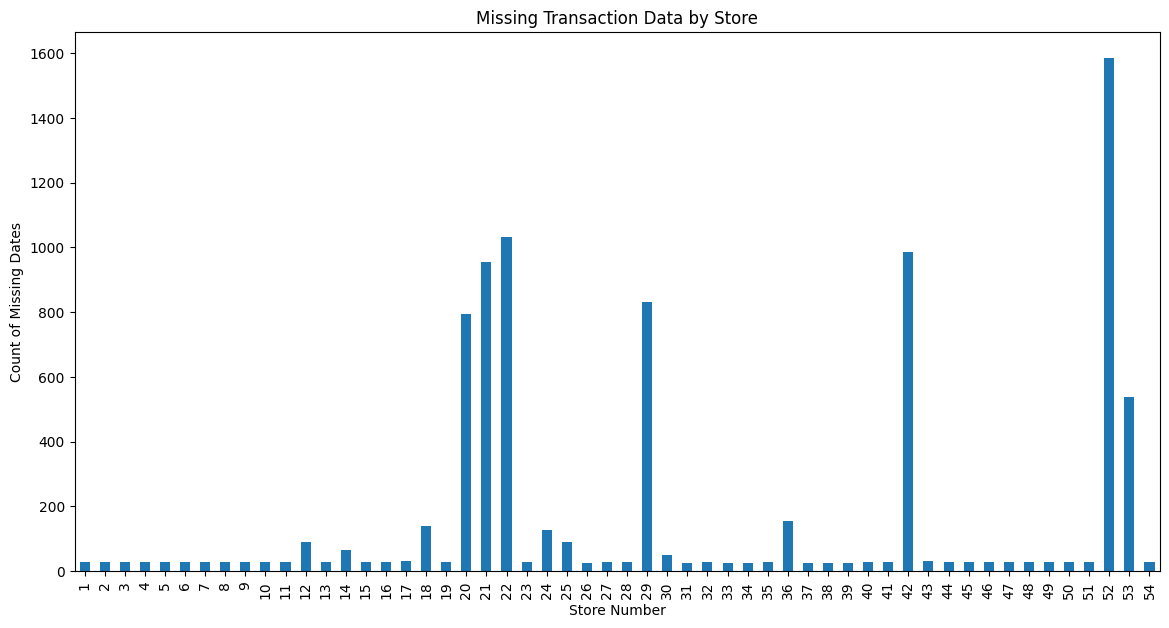

 30%|██▉       | 16/54 [00:24<01:03,  1.67s/it]C:\Users\danil\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 43%|████▎     | 23/54 [00:35<00:43,  1.39s/it]

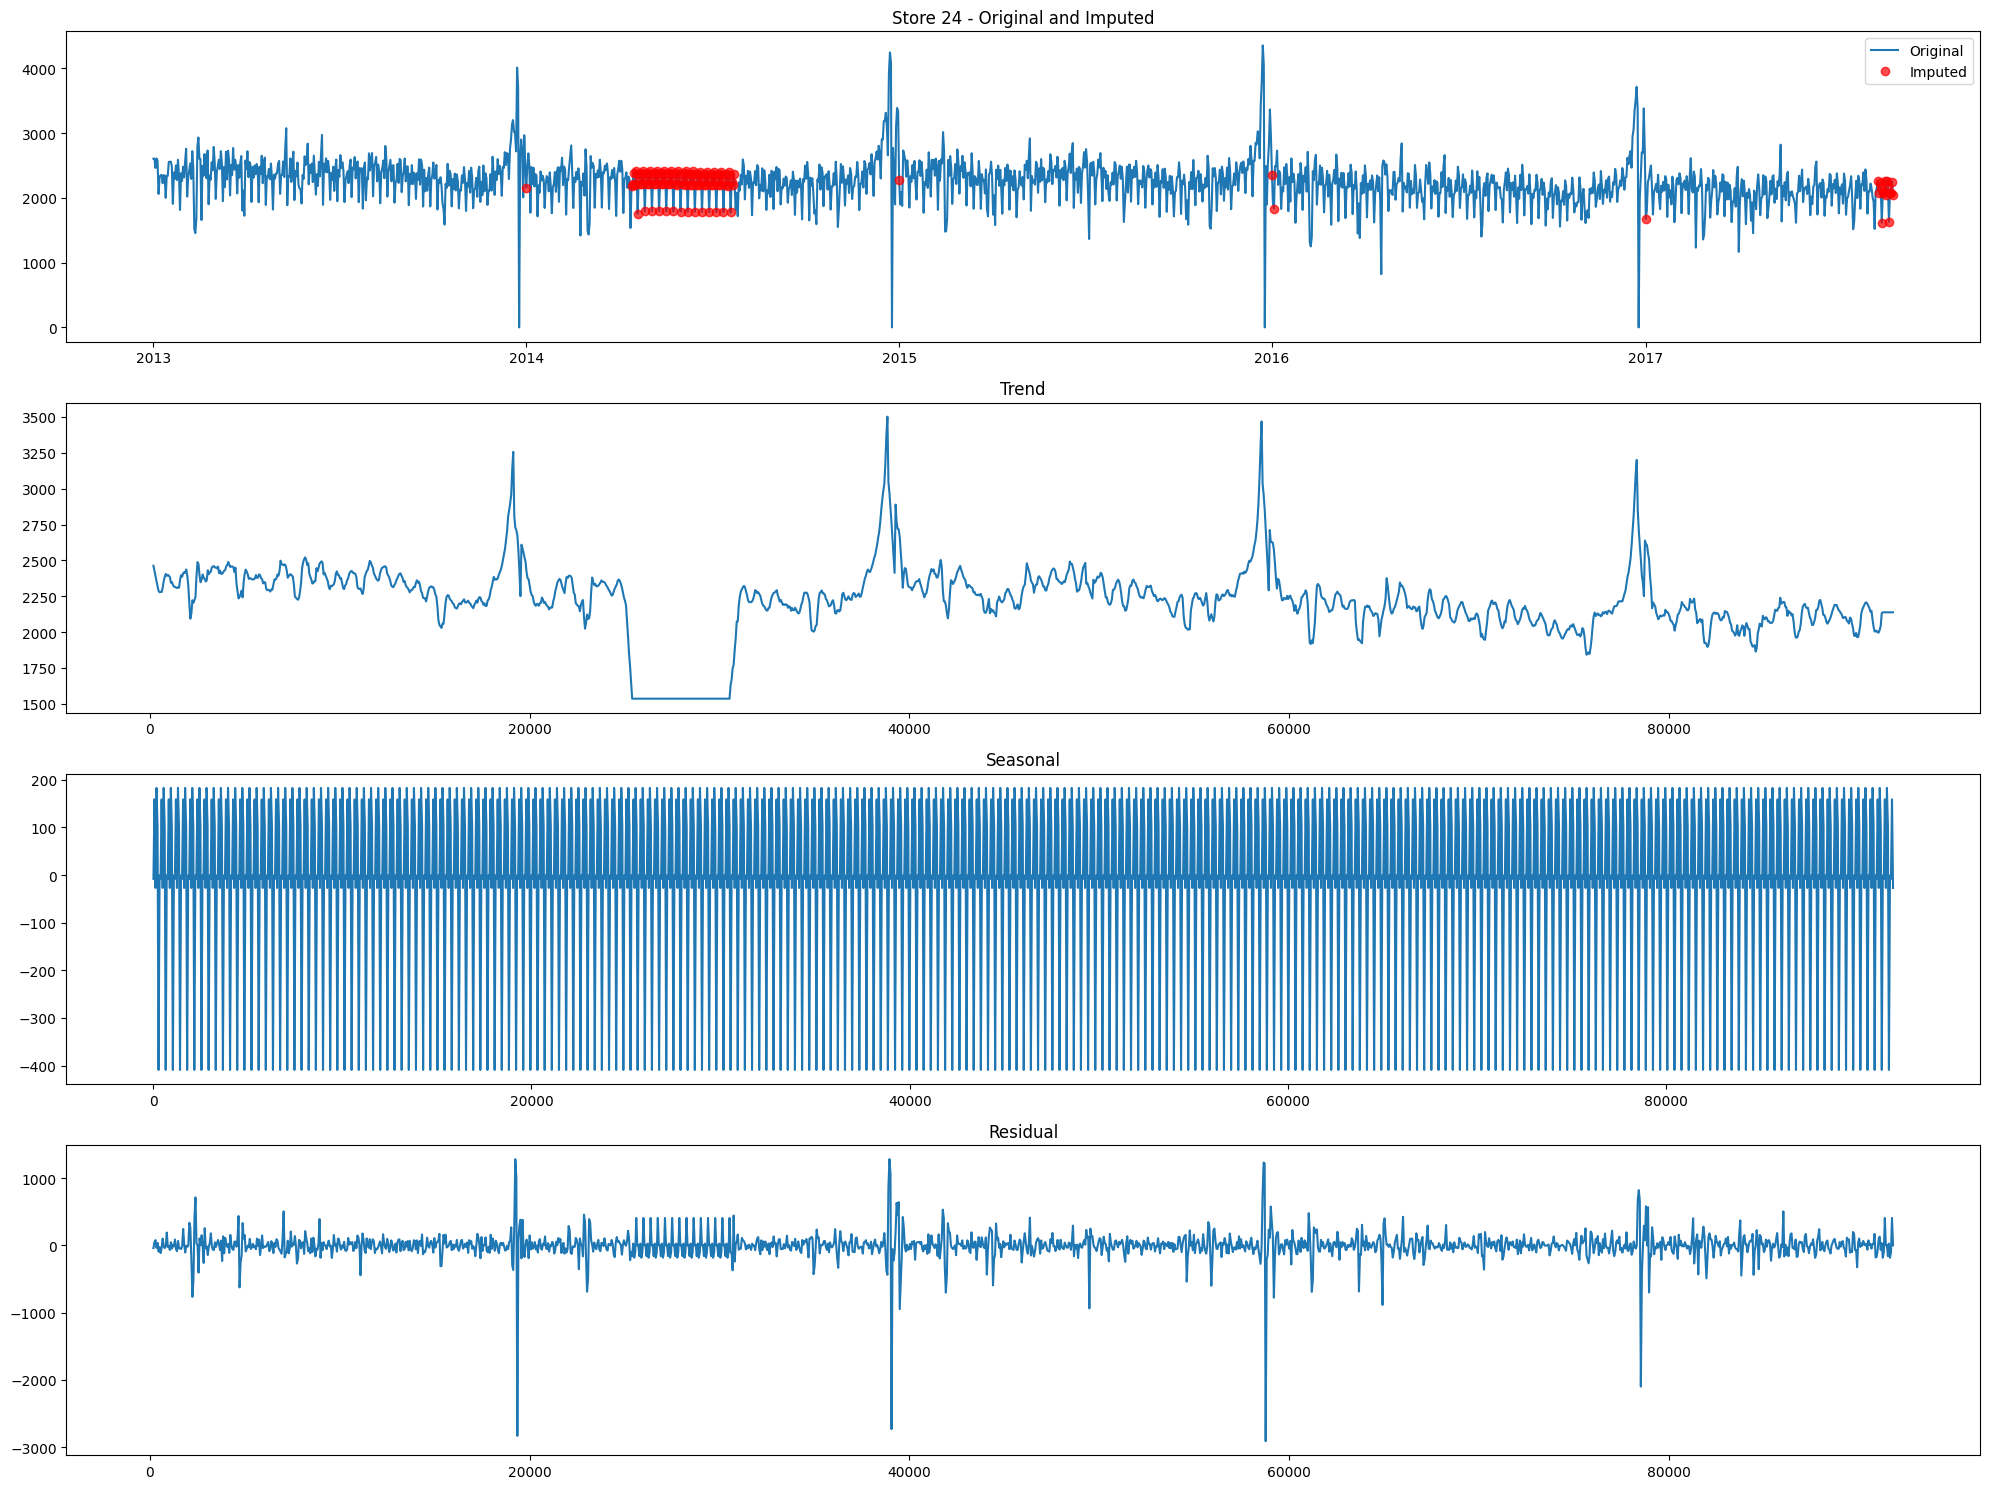

 46%|████▋     | 25/54 [00:39<00:45,  1.56s/it]C:\Users\danil\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 57%|█████▋    | 31/54 [00:49<00:37,  1.64s/it]C:\Users\danil\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 54/54 [01:23<00:00,  1.55s/it]



Missing values after imputation: 0

Sample of imputed data:
           date  store_nbr  transactions
18   2013-01-01         18          1635
72   2013-01-02         18          1635
126  2013-01-03         18          1484
180  2013-01-04         18          1238
234  2013-01-05         18          1323
288  2013-01-06         18          1405
342  2013-01-07         18          1369
396  2013-01-08         18          1388
450  2013-01-09         18          1206
504  2013-01-10         18          1219
558  2013-01-11         18          1221
612  2013-01-12         18          1217
666  2013-01-13         18          1376
720  2013-01-14         18          1314
774  2013-01-15         18          1350
828  2013-01-16         18          1313
882  2013-01-17         18          1249
936  2013-01-18         18          1209
990  2013-01-19         18          1362
1044 2013-01-20         18          1347

Total imputed values: 5633
Stores with imputed values: 54
Imputed values per 

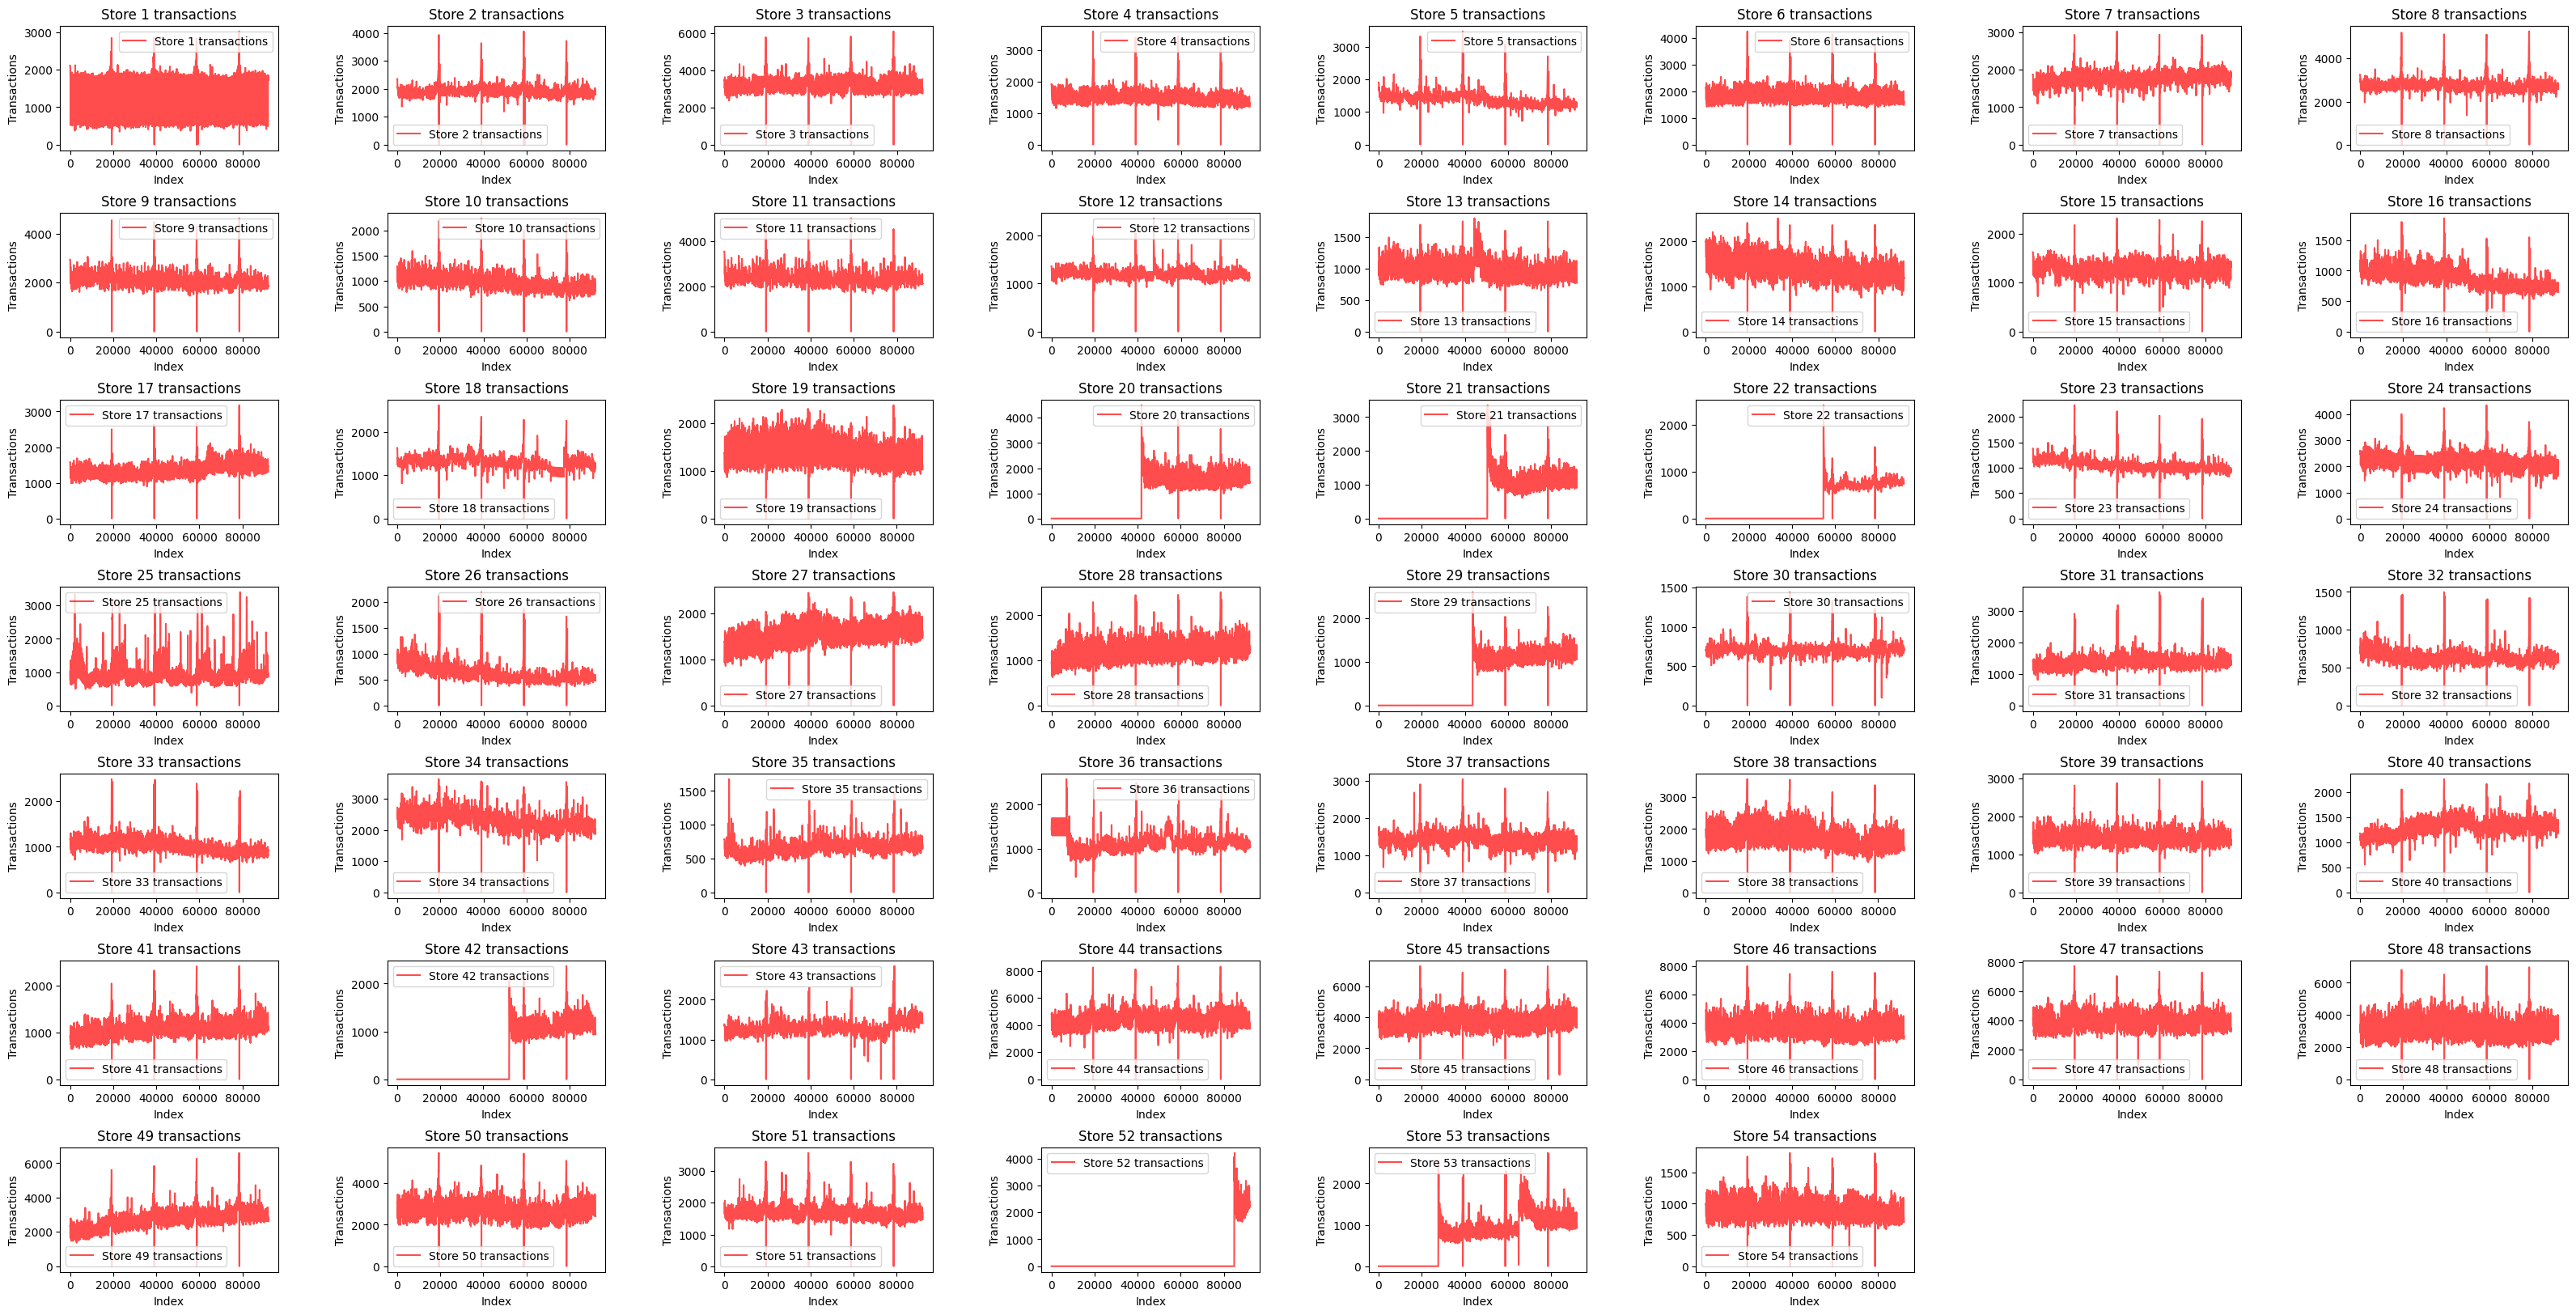

In [12]:
# Convert 'date' column to datetime in the transactions set and sort values
transactions['date'] = pd.to_datetime(transactions['date'])
transactions = transactions.sort_values(by=['date', 'store_nbr'])

# Create a complete date range from the minimum to the maximum date found in the dataset
date_range = pd.date_range(start=data['date'].min(), end=data['date'].max())
store_numbers = transactions['store_nbr'].unique()

# Create a DataFrame for the full date range for each store (Cartesian product of dates and store numbers)
full_grid = pd.MultiIndex.from_product([date_range, store_numbers], names=['date', 'store_nbr'])
full_grid_df = pd.DataFrame(index=full_grid).reset_index()

# Ensure 'store_nbr' is the correct type
full_grid_df['store_nbr'] = full_grid_df['store_nbr'].astype(transactions['store_nbr'].dtype)

# Merge the full grid with the original transactions data
full_transactions = full_grid_df.merge(transactions, on=['date', 'store_nbr'], how='left')

# Check for missing data in the 'transactions' column
total_missing = full_transactions['transactions'].isna().sum()
missing_percentage = total_missing / len(full_transactions) * 100
print('Total missing entries:', total_missing, f'({missing_percentage:.2f}%)')

# Find and analyze the missing entries
missing_data = full_transactions[full_transactions['transactions'].isna()]
missing_by_store = missing_data.groupby('store_nbr').size()
missing_threshold = 0.05
problem_stores = missing_by_store[missing_by_store / len(date_range) > missing_threshold].index
problem_list = ', '.join(map(str, problem_stores))
print(f'Stores with more than {missing_threshold * 100}% missing data: {problem_list}')

# Plotting the number of missing entries per store
missing_by_store.plot(kind='bar', figsize=(14, 7))
plt.title('Missing Transaction Data by Store')
plt.xlabel('Store Number')
plt.ylabel('Count of Missing Dates')
plt.show()

# Assuming the function `impute_transactions` is defined and available
imputed_transactions, imputation_log = impute_transactions(transactions, full_transactions, plot_store=24)

# Verify results
missing_after = imputed_transactions['transactions'].isna().sum()
print(f"\nMissing values after imputation: {missing_after}")

# Round the imputed values to integers
imputed_transactions['transactions'] = imputed_transactions['transactions'].round().astype('Int64')

# Display some of the imputed data
print("\nSample of imputed data:")
print(imputed_transactions[imputed_transactions['store_nbr'].isin([18, 20, 21])].head(20))

# Calculate and print imputation statistics
total_imputed = sum(len(log) for log in imputation_log.values())
print(f"\nTotal imputed values: {total_imputed}")
print(f"Stores with imputed values: {len(imputation_log)}")
print("Imputed values per store:")
for store, log in imputation_log.items():
    print(f"Store {store}: {len(log)} imputed values")

# Assuming the function `trend_features` is defined and available
transactions_transformed = trend_features(imputed_transactions, 'transactions', ma_type, ma_length, lags)

# Plot the transactions for all stores, highlighting those with missing data
store_numbers = imputed_transactions['store_nbr'].unique()
num_stores = len(store_numbers)
cols = 8
rows = num_stores // cols + (num_stores % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(40, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, store_number in enumerate(store_numbers):
    ax = axs[i // cols, i % cols]
    txs = imputed_transactions[imputed_transactions['store_nbr'] == store_number]['transactions']
    ax.plot(txs, label=f'Store {store_number} transactions', color='red', alpha=0.7)
    ax.set_title(f'Store {store_number} transactions')
    ax.set_xlabel('Index')
    ax.set_ylabel('Transactions')
    ax.legend()

for j in range(i + 1, rows * cols):
    axs[j // cols, j % cols].axis('off')

plt.show()

*Observation* - some stores are missing transaction data for certain dates. We have imputed the missing data using SARIMAX and trend features.
Despite the imputation, we can see that some stores were probably opened later and have no data for the initial period, which is why the transactions are zero.

---

## Feature Engineering - Average Transactions
This section focuses on calculating the average transactions for all stores on all days and merging the average transactions with the main data.
This will help hte model to learn the demand patterns for all stores.

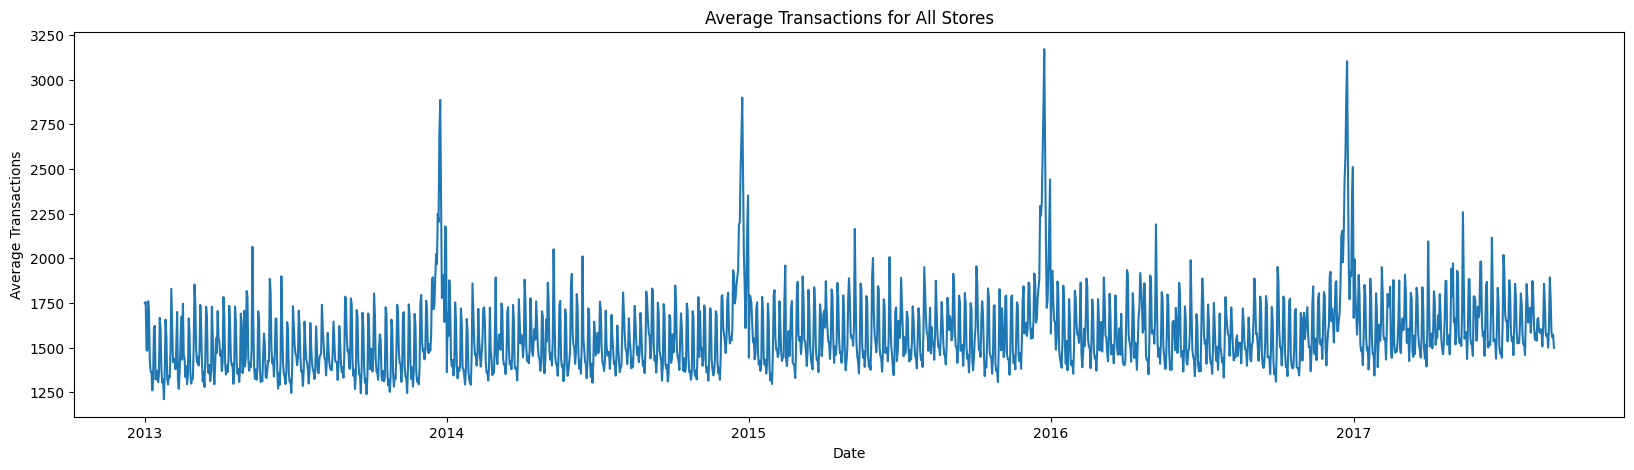

,id,date,store_nbr,family,sales,onpromotion,original_id,is_test,city,state,...,transactions_ema_91_lag_1,transactions_ema_91_lag_1_detrended,transactions_ema_91_lag_1_diff,transactions_ema_91_lag_7,transactions_ema_91_lag_7_detrended,transactions_ema_91_lag_7_diff,transactions_ema_91_lag_28,transactions_ema_91_lag_28_detrended,transactions_ema_91_lag_28_diff,average_transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,0,Quito,Pichincha,...,2111.000000,0.000000,0.000000,2111.000000,67.429443,0.000000,2111.000000,255.498779,0.000000,1747.703704
1,1,2013-01-01,1,BABY CARE,0.0,0,1,0,Quito,Pichincha,...,2111.000000,0.000000,0.000000,2111.000000,67.429443,0.000000,2111.000000,255.498779,0.000000,1747.703704
2,2,2013-01-01,1,BEAUTY,0.0,0,2,0,Quito,Pichincha,...,2111.000000,0.000000,0.000000,2111.000000,67.429443,0.000000,2111.000000,255.498779,0.000000,1747.703704
3,3,2013-01-01,1,BEVERAGES,0.0,0,3,0,Quito,Pichincha,...,2111.000000,0.000000,0.000000,2111.000000,67.429443,0.000000,2111.000000,255.498779,0.000000,1747.703704
4,4,2013-01-01,1,BOOKS,0.0,0,4,0,Quito,Pichincha,...,2111.000000,0.000000,0.000000,2111.000000,67.429443,0.000000,2111.000000,255.498779,0.000000,1747.703704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036787,3029263,2017-08-31,54,POULTRY,NaN,0,3029263,1,El Carmen,Manabi,...,820.151855,2.459839,-2.225586,815.359741,-2.332275,-2.452454,811.405945,-6.286072,-2.209045,1498.5
3036788,3029264,2017-08-31,54,PREPARED FOODS,NaN,0,3029264,1,El Carmen,Manabi,...,820.151855,2.459839,-2.225586,815.359741,-2.332275,-2.452454,811.405945,-6.286072,-2.209045,1498.5
3036789,3029265,2017-08-31,54,PRODUCE,NaN,1,3029265,1,El Carmen,Manabi,...,820.151855,2.459839,-2.225586,815.359741,-2.332275,-2.452454,811.405945,-6.286072,-2.209045,1498.5
3036790,3029266,2017-08-31,54,SCHOOL AND OFFICE SUPPLIES,NaN,0,3029266,1,El Carmen,Manabi,...,820.151855,2.459839,-2.225586,815.359741,-2.332275,-2.452454,811.405945,-6.286072,-2.209045,1498.5


In [13]:
# Merge the transactions data with the main data
data = data.merge(transactions_transformed, on=['store_nbr', 'date'], how='left')

# calculate average transaction for all stores on all days
average_transactions = data.groupby('date')['transactions'].mean().reset_index()
average_transactions = average_transactions.rename(columns={'transactions': 'average_transactions'})

# merge the average transactions with the data
data = data.merge(average_transactions, on='date', how='left')

# plot the average transactions
plt.figure(figsize=(20, 5))
plt.plot(average_transactions['date'], average_transactions['average_transactions'])
plt.title('Average Transactions for All Stores')
plt.xlabel('Date')
plt.ylabel('Average Transactions')
plt.show()

data

# Transforming and Scaling Data
Here we do the following:
1. Transform 'onpromotion' on a log scale.
2. Transform target 'sales' on a log scale.
3. Scale all float and int columns.
4. Encode categorical variables.
5. Drop unnecessary columns.
6. Downcast the data types to save memory.

In [14]:
# scale all float and int columns
def scale_data(data):
    # Identify numerical columns to scale
    numerical_columns = data.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns

    # Exclude columns that shouldn't be scaled
    columns_to_exclude = ['store_nbr', 'id', 'sales', 'onpromotion', 'original_id',
                          'is_test', 'state_city', 'is_holiday', 'is_workday', 'is_event',
                          'is_sunday', 'is_bridge', 'day', 'day_of_month', 'week', 'day_of_week'
                          'week_of_month', 'month', 'quarter', 'year', 'family', 'is_month_start', 'is_month_end']
    columns_to_scale = [col for col in numerical_columns if col not in columns_to_exclude]

    # Initialize the scaler
    scaler = StandardScaler()

    # Scale the numerical columns for each store-family combination
    for col in columns_to_scale:
        # Group by store_nbr and family
        grouped = data.groupby(['store_nbr', 'family'])

        # Define a function to scale each group
        def scale_group(group):
            train_data = group[group['is_test'] == 0][col].values.reshape(-1, 1)
            if len(train_data) > 0:
                scaler.fit(train_data)
                return pd.Series(scaler.transform(group[col].values.reshape(-1, 1)).flatten(), index=group.index)
            else:
                return group[col]  # Return unscaled if no training data

        # Apply scaling to each group
        data[f'{col}_scaled'] = grouped.apply(scale_group).reset_index(level=[0,1], drop=True)

    # Drop original unscaled columns
    data = data.drop(columns=columns_to_scale)

    return data

# transform onpromotion on log scale
data['onpromotion'] = np.log1p(data['onpromotion'])
# scale all float and int columns
data['sales'] = np.log1p(data['sales'])
# scale data
data = scale_data(data)

# Encode categorical variables
categorical_columns = ['family', 'season']
for col in categorical_columns:
    if col in data.columns:
        data[col] = pd.Categorical(data[col]).codes

# Drop unnecessary columns
columns_to_drop = ['city', 'state', 'state_city', 'date']
data = data.drop(columns_to_drop, axis=1)

data = downcast_df(data)
data

C:\Users\danil\AppData\Local\Temp\ipykernel_3248\586854940.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data[f'{col}_scaled'] = grouped.apply(scale_group).reset_index(level=[0,1], drop=True)
C:\Users\danil\AppData\Local\Temp\ipykernel_3248\586854940.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data[f'{col}_scaled'] = grouped.apply(scale_group).reset_index(level=[0,1], drop=True)
C:\Users\dan

,id,store_nbr,family,sales,onpromotion,original_id,is_test,cluster_1,cluster_2,cluster_3,...,transactions_ema_91_lag_1_scaled,transactions_ema_91_lag_1_detrended_scaled,transactions_ema_91_lag_1_diff_scaled,transactions_ema_91_lag_7_scaled,transactions_ema_91_lag_7_detrended_scaled,transactions_ema_91_lag_7_diff_scaled,transactions_ema_91_lag_28_scaled,transactions_ema_91_lag_28_detrended_scaled,transactions_ema_91_lag_28_diff_scaled,average_transactions_scaled
0,0,1,0,0.0,0.000000,0,0,False,False,False,...,7.353307,-0.02783,0.038820,6.700965,3.099160,0.033982,5.312344,4.245011,0.033125,0.833446
1,1,1,1,0.0,0.000000,1,0,False,False,False,...,7.353307,-0.02783,0.038820,6.700965,3.099160,0.033982,5.312344,4.245011,0.033125,0.833446
2,2,1,2,0.0,0.000000,2,0,False,False,False,...,7.353307,-0.02783,0.038820,6.700965,3.099160,0.033982,5.312344,4.245011,0.033125,0.833446
3,3,1,3,0.0,0.000000,3,0,False,False,False,...,7.353307,-0.02783,0.038820,6.700965,3.099160,0.033982,5.312344,4.245011,0.033125,0.833446
4,4,1,4,0.0,0.000000,4,0,False,False,False,...,7.353307,-0.02783,0.038820,6.700965,3.099160,0.033982,5.312344,4.245011,0.033125,0.833446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036787,3029263,54,28,NaN,0.000000,3029263,1,False,False,True,...,-1.349775,0.63342,-0.534595,-1.415619,-0.415682,-0.596400,-1.344271,-0.461500,-0.532080,-0.347005
3036788,3029264,54,29,NaN,0.000000,3029264,1,False,False,True,...,-1.349775,0.63342,-0.534595,-1.415619,-0.415682,-0.596400,-1.344271,-0.461500,-0.532080,-0.347005
3036789,3029265,54,30,NaN,0.693147,3029265,1,False,False,True,...,-1.349775,0.63342,-0.534595,-1.415619,-0.415682,-0.596400,-1.344271,-0.461500,-0.532080,-0.347005
3036790,3029266,54,31,NaN,0.000000,3029266,1,False,False,True,...,-1.349775,0.63342,-0.534595,-1.415619,-0.415682,-0.596400,-1.344271,-0.461500,-0.532080,-0.347005


# Prepare Data for Model Training
Here we prepare the data for model training by splitting it into train and test sets, preparing features and target, and defining the RMSLE metric.

In [21]:
# Split into train and test
data_train = data[data['is_test'] == 0].drop('is_test', axis=1)
data_test = data[data['is_test'] == 1].drop('is_test', axis=1)
# Split train into train and validation
split_percentage = 0.995 # 99.5% train, 0.5% validation
train_size = int(len(data_train) * split_percentage)
train = data_train[:train_size]
val = data_train[train_size:]

# Prepare features and target
features = [col for col in train.columns if col not in ['sales', 'id', 'original_id']]
X_train, y_train = train[features], train['sales']
X_val, y_val = val[features], val['sales']
X_test = data_test[features]

# Model Optimization and Training
This section focuses on optimizing and training the LightGBM and CatBoost models.

In [17]:
# Define RMSLE metric
def rmsle(y_true, y_pred):
    y_pred_clipped = np.clip(y_pred, 0, None)
    epsilon = 1e-8
    msle = mean_squared_error(np.log1p(y_true + epsilon), np.log1p(y_pred_clipped + epsilon))
    return np.sqrt(msle)

# Define the optimization function for LightGBM
def optimize_lgb_params(trial):
    hyper_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',

        # Core parameters
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),

        # Regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),

        # Subsampling
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),

        # Performance
        'max_bin': trial.suggest_categorical('max_bin', [255, 510]),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
    }

    # Add conditional parameters
    if trial.suggest_categorical('enable_max_depth', [True, False]):
        hyper_params['max_depth'] = trial.suggest_int('max_depth', 3, 12)

    model = lgb.LGBMRegressor(**hyper_params)

    # Use LightGBM's built-in early stopping
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)])

    preds = model.predict(X_val)
    return rmsle(y_val, preds)

def optimize_lgb(trials=100):
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize_lgb_params, n_trials=trials, show_progress_bar=True)
    print("Best LightGBM params:", study.best_params)
    return study.best_params

start = time.time()
# best_lgb_params = optimize_lgb(trials=100)
end = time.time()
print(f"Time taken: {end - start:.2f} seconds")

Time taken: 0.00 seconds


In [18]:
# Use the best hyperparameters on the model
hyper_params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'learning_rate': 0.09182113434423363,
                'n_estimators': 1000,
                'num_leaves': 92,
                'reg_alpha': 2.3021594117564076e-06,
                'reg_lambda': 6.713811557814796e-06,
                'min_child_samples': 47,
                'subsample': 0.8974905945143589,
                'colsample_bytree': 0.5717691394379883,
                'max_bin': 255,
                'feature_fraction': 0.8481341203063759,
                'enable_max_depth': False
                }

# Train LGBM model
lgbm = lgb.LGBMRegressor(**hyper_params)
lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='l1')

# Evaluate the model
lgbm_pred = lgbm.predict(X_val)
lgbm_rmsle = rmsle(y_val, lgbm_pred)
print(f"LightGBM RMSLE: {lgbm_rmsle}")

# Predict on test set
lgbm_pred = lgbm.predict(X_test)
# Inverse the log transformation
lgbm_pred = np.expm1(lgbm_pred)

[LightGBM] [Warning] Unknown parameter: enable_max_depth
[LightGBM] [Warning] feature_fraction is set=0.8481341203063759, colsample_bytree=0.5717691394379883 will be ignored. Current value: feature_fraction=0.8481341203063759
[LightGBM] [Warning] Unknown parameter: enable_max_depth
[LightGBM] [Warning] feature_fraction is set=0.8481341203063759, colsample_bytree=0.5717691394379883 will be ignored. Current value: feature_fraction=0.8481341203063759
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13259
[LightGBM] [Info] Number of data points in the train set: 2993238, number of used features: 88
[LightGBM] [Warning] Unknown parameter: enable_max_depth
[LightGBM] [Warning] feature_fraction is set=0.8481341203063759, colsample_bytree=0.5717691394379883 will be ignored. Current value:

In [19]:
output = pd.DataFrame(index=data_test['id'])
output['sales'] = lgbm_pred
output['sales'] = output['sales'].clip(0)
# round and convert to int32
output.index = output.index.round().astype('int32')
output

,sales
id,
3000888,4.251650
3000889,0.004189
3000890,5.934645
3000891,2663.306079
3000892,0.000000
...,...
3029263,58.336859
3029264,41.705884
3029265,510.182464


In [20]:
output.to_csv('submission.csv')

## Notes
Our model can be further improved by tuning hyperparameters and adding more features.
This implementation can be improved by using more advanced techniques like stacking and blending.

Despite the decent result, it is imprortant to understand that such approach is not suitable for real-world applications, as it is not scalable and requires manual intervention.
To deploy a model in production, we need to follow the following steps:
1. Make model to update its features automatically based on the most recent data + predictions. In this implementation, we use the whole dataset to train the model.
2. Use a pipeline to automate the process of training, validation, and testing.
3. Use a pipeline to automate the process of hyperparameter tuning.